In [1]:
import pandas as pd
import sklearn as sklearn
import numpy as np
import time
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lg
import optuna
import optuna.integration.lightgbm as lgb
import xgboost as xgb
import pickle
import os

from sklearn.pipeline import Pipeline
from pandas.core.frame import DataFrame
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from datetime import date
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import RepeatedKFold
from sklearn.svm import LinearSVR
from sklearn.svm import SVR

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

## Helper functions

In [2]:
_СORRELATION_MATRIX_PATH_ = 'corr_matrix.pickle'
_СHURN_PATH_ = 'churn_model.pcl'
_CHURN_PATH_REDUCED_ = 'churn_model_reduced.pcl' 

In [3]:
def get_float_cols(df:DataFrame):
    return df.select_dtypes(include=float).columns.tolist()

def get_int_cols(df:DataFrame):
    return df.select_dtypes(include=int).columns.tolist()

def get_number_cols(df:DataFrame):
    return df.select_dtypes(np.number).columns.tolist()

def get_obj_cols(df:DataFrame):
    return list(df.select_dtypes(include=object).columns)

In [4]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
def split_test_train(df:DataFrame):
    test, train = df[df['ind'].eq('test')], df[df['ind'].eq('train')]
    test = test.drop(['ind'], axis=1)
    train = train.drop(['ind'], axis=1)
    return test, train
    
def combine_test_train(test:DataFrame, train:DataFrame):
    combine = pd.concat([test.assign(ind='test'), train.assign(ind='train')])
    target = train['SalePrice']
    test_ids = test['Id']
    return combine, target, test_ids

def combine_data(train_df, train_num, train_dpi, test_df, test_num, test_dpi):
    df_combine = pd.concat([train_df.assign(ind='train'), test_df.assign(ind='test')])
    df_combine_num = pd.concat([train_num.assign(ind='train'), test_num.assign(ind='test')])
    df_combine_dpi = pd.concat([train_dpi.assign(ind='train'), test_dpi.assign(ind='test')])
    return df_combine, df_combine_num, df_combine_dpi

In [6]:
def get_correlation_matrix(df:DataFrame):
    
    if os.path.exists(_СORRELATION_MATRIX_PATH_) == False:
        corr_matrix = df.corr()
        pickle.dump(corr_matrix, open(_СORRELATION_MATRIX_PATH_, 'wb'))
    else:
        corr_matrix = pickle.load(open(_СORRELATION_MATRIX_PATH_, 'rb'))
    
    return corr_matrix

In [7]:
def remove_aggr_function(str_to_check:str) -> str:
    parts = str_to_check.split('_')
    if (len(parts) > 4):
        index_to_remove = len(parts) - 2
        parts.remove(parts[index_to_remove])
        result = '_'.join(parts)
        return result
    else:
        return str_to_check

In [8]:
def reduce_churn_data():

    if os.path.exists(_CHURN_PATH_REDUCED_) == False:
        if os.path.exists(_СHURN_PATH_) == True: 
            
            with open(_СHURN_PATH_, 'rb') as file:
                deserialized_object = pickle.load(file)

            deserialized_object = list(deserialized_object)
        
            # reduce size
            train_df= reduce_mem_usage(deserialized_object[1][1])
            train_num_reduced = reduce_mem_usage(deserialized_object[1][2])
            train_dpi_reduced = reduce_mem_usage(deserialized_object[1][3])

            test_df = reduce_mem_usage(deserialized_object[2][1])
            test_num_reduced = reduce_mem_usage(deserialized_object[2][2])
            test_dpi_reduced = reduce_mem_usage(deserialized_object[2][3])
            
            # dump data back
            deserialized_object = tuple([[train_df, train_num_reduced, train_dpi_reduced], [test_df, test_num_reduced, test_dpi_reduced]])
            pickle.dump(deserialized_object, open(_CHURN_PATH_REDUCED_, 'wb'))
    else:
        print(f'{_CHURN_PATH_REDUCED_} already exist')

In [9]:
def load_churn_data():

    with open(_СHURN_PATH_, 'rb') as file:
        deserialized_object = pickle.load(file)

    train_df = deserialized_object[1][1]
    train_num = deserialized_object[1][2]
    train_dpi = deserialized_object[1][3]

    test_df = deserialized_object[2][1]
    test_num = deserialized_object[2][2]
    test_dpi = deserialized_object[2][3]

    return train_df, train_num, train_dpi, test_df, test_num, test_dpi

In [10]:
def load_churn_reduced():

    with open(_CHURN_PATH_REDUCED_, 'rb') as file:
        deserialized_object = pickle.load(file)

    train_df = deserialized_object[0][0]
    train_num = deserialized_object[0][1]
    train_dpi = deserialized_object[0][2]

    test_df = deserialized_object[1][0]
    test_num = deserialized_object[1][1]
    test_dpi = deserialized_object[1][2]

    return train_df, train_num, train_dpi, test_df, test_num, test_dpi

In [11]:
def get_heatmap_matrix(df:DataFrame):
    corr_matrix = get_correlation_matrix(df)
    heatmap_matrix = pd.DataFrame(corr_matrix['target'].abs())
    heatmap_matrix = heatmap_matrix.sort_values(by='target', ascending=False)
    heatmap_matrix = heatmap_matrix.drop(index=['target'])
    heatmap_matrix = heatmap_matrix[heatmap_matrix['target'] > 0.05]
    return heatmap_matrix

In [12]:
def plot_heatmap(df:DataFrame):
    heatmap_matrix = get_heatmap_matrix(df)
    plt.figure(figsize=(40, 120))
    heatmap = sns.heatmap(heatmap_matrix, vmin=-1, vmax=1, annot=True, cmap='BrBG')
    heatmap.set_title('Features Correlating with Churn Rate', fontdict={'fontsize':18}, pad=16);
    return heatmap_matrix

In [32]:
def get_important_features(df:DataFrame):
    heatmap_matrix = get_heatmap_matrix(df)
    df_features = heatmap_matrix.reset_index()
    df_features = df_features.rename(columns = {'index':'feature'})
    df_features['feature_group'] = df_features['feature'].apply(remove_aggr_function)
    df_features = df_features[['feature', 'feature_group', 'target']]
    sorted_features = df_features.sort_values(by=['feature_group', 'target'], ascending = [False, False])
    important_features = sorted_features.groupby('feature_group').first()
    return important_features

In [33]:
def is_short_number(number:str) -> bool:
    if (number.isdigit() and len(number) <= 4):
        return True
    return False

def is_life(number:str) -> bool:
    if (len(number) == 12 and (number[2:5] in ['063', '093' ])):
        return True
    return False

def is_kyivstar(number:str) -> bool:
    if (len(number) == 12 and (number[2:5] in ['067', '097', '068', '098'])):
        return True
    return False

## Verify is set balanced or not

In [15]:
train_df, train_num, train_dpi, test_df, test_num, test_dpi = load_churn_reduced()
df_combine, df_combine_num, df_combine_dpi = combine_data(train_df, train_num, train_dpi, test_df, test_num, test_dpi)

In [16]:
churned = len(df_combine[df_combine['target'] == 1])
not_churned = len(df_combine[df_combine['target'] == 0])

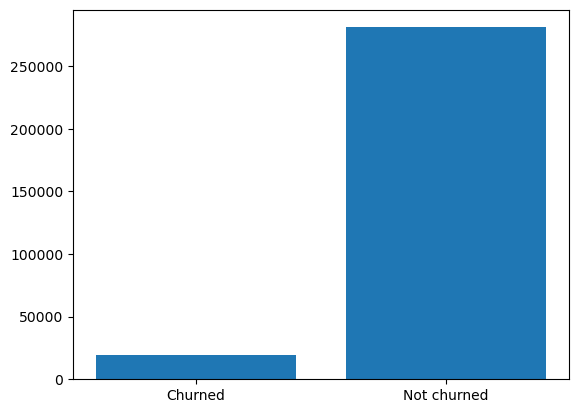

In [17]:
y = [churned, not_churned]
x = ['Churned', 'Not churned']
plt.bar(x,y)
plt.show()

## Feature engineering
#### Check inbound calls from non-vodaphone number
#### Check outbound calls to non-vodaphone number
#### SMS from non-vodaphone number
#### SMS to non-vodaphone number

## Explore numbers abonent had communication with + frequency

In [27]:
churned = df_combine[df_combine['target'] == 1]
churned_with_nums = pd.merge(churned, df_combine_num, on='abon_id', how='left')
churned_numbers = list(churned_with_nums['bnum'].unique())

non_churned = df_combine[df_combine['target'] == 0]
non_churned_with_nums = pd.merge(non_churned, df_combine_num, on='abon_id', how='left')
non_churned_numbers = list(non_churned_with_nums['bnum'].unique())

number_abon_had_communicated = (set(churned_numbers) - set(non_churned_numbers))
df_number_abon_had_communicated = pd.DataFrame(number_abon_had_communicated, columns= ['bnum'])

In [28]:
churned_with_nums[churned_with_nums['bnum'].isin(list(number_abon_had_communicated))]

,Ama_rchrgmnt_sum_max_mnt1,content_clc_mea_mnt1,content_cnt_max_mnt1,voice_out_short_part_max_mnt1,voice_mts_in_nrest_part_std_mnt1,num_act_days_max_mnt1,sms_roam_clc_min_mnt1,voice_in_cmpttrs_avg_durmin_mnt1,com_num_part_mea_mnt1,pay_avg_mea_mnt1,...,abon_id,ind_x,bnum,call_cnt_out,call_cnt_in,call_dur_out,call_dur_in,cnt_sms_out,cnt_sms_in,ind_y
102,0,0.0,9.671875,0.000000,0.000000,4.785156,0,14.468750,1.162109,0.000000,...,1933638.0,train,b'380679520201',0.000000,1.480469,0.000000,21.453125,0.000000,0.000000,train
305,0,0.0,11.617188,1.010742,0.000000,5.324219,0,11.804688,1.048828,2.570312,...,5280263.0,train,b'380979774316',1.480469,0.000000,15.320312,0.000000,0.000000,0.000000,train
471,0,0.0,14.789062,1.006836,1.043945,5.324219,0,18.984375,1.155273,24.765625,...,6400769.0,train,b'uaswitch',0.000000,0.000000,0.000000,0.000000,0.000000,3.589844,train
790,0,0.0,13.226562,0.000000,0.000000,5.324219,0,0.000000,0.000000,0.000000,...,9840437.0,train,b'affiliate',0.000000,0.000000,0.000000,0.000000,0.000000,6.750000,train
1099,0,0.0,10.265625,0.000000,1.019531,5.324219,0,0.000000,1.015625,14.328125,...,11590315.0,train,b'380442371358',1.480469,0.000000,26.046875,0.000000,0.000000,0.000000,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56153,0,0.0,11.617188,1.002930,1.009766,5.324219,0,14.085938,1.181641,11.617188,...,130192328.0,test,b'380444565002',1.480469,0.000000,11.359375,0.000000,0.000000,0.000000,test
56170,0,0.0,14.968750,1.011719,0.000000,5.324219,0,15.281250,1.476562,0.000000,...,130196216.0,test,b'380660203050',0.000000,0.000000,0.000000,0.000000,0.000000,1.480469,test
56202,0,0.0,9.351562,1.004883,0.000000,5.324219,0,0.000000,1.358398,11.617188,...,130200864.0,test,b'380444961496',2.921875,0.000000,22.921875,0.000000,0.000000,0.000000,test
56243,0,0.0,10.554688,1.006836,0.000000,5.324219,0,15.148438,1.136719,0.000000,...,130263832.0,test,b'4908',0.000000,0.000000,0.000000,0.000000,1.480469,0.000000,test


353

In [31]:
df_combine

,Ama_rchrgmnt_sum_max_mnt1,content_clc_mea_mnt1,content_cnt_max_mnt1,voice_out_short_part_max_mnt1,voice_mts_in_nrest_part_std_mnt1,num_act_days_max_mnt1,sms_roam_clc_min_mnt1,voice_in_cmpttrs_avg_durmin_mnt1,com_num_part_mea_mnt1,pay_avg_mea_mnt1,...,MV_DOU_OT,MV_SERV_Y_WO_AF,MV_Migr_To,MV_SERV_RLH,MV_DOU_PPM_VF,MV_DOU_Neg_Bal,MV_ot_total,target,abon_id,ind
0,0,0.0,13.843750,1.480469,0.000000,5.324219,0,19.046875,1.657227,0.000000,...,1.480469,NaN,0.0,NaN,13.007812,NaN,0.0,0.0,1545052.0,train
1,0,0.0,11.359375,1.000000,1.000000,5.324219,0,0.000000,1.000977,15.015625,...,1.480469,NaN,0.0,NaN,18.171875,NaN,0.0,0.0,1545235.0,train
2,0,0.0,10.265625,0.000000,0.000000,5.324219,0,0.000000,1.015625,11.617188,...,1.480469,NaN,0.0,NaN,NaN,NaN,0.0,0.0,1549358.0,train
3,0,0.0,9.976562,1.033203,1.000000,5.324219,0,0.000000,1.002930,11.617188,...,1.480469,NaN,0.0,NaN,NaN,NaN,0.0,0.0,1549591.0,train
4,0,0.0,6.750000,1.000977,1.000977,5.324219,0,28.859375,1.047852,0.000000,...,NaN,1.0,0.0,NaN,13.007812,NaN,NaN,0.0,1558772.0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,0,0.0,11.859375,1.002930,1.000977,5.324219,0,9.671875,1.119141,0.000000,...,1.480469,NaN,0.0,NaN,NaN,NaN,0.0,1.0,130753144.0,test
149996,0,0.0,8.687500,1.023438,1.009766,5.324219,0,0.000000,1.029297,0.000000,...,1.480469,NaN,0.0,NaN,NaN,NaN,0.0,0.0,130753520.0,test
149997,0,0.0,11.359375,1.003906,1.000000,5.324219,0,15.234375,1.214844,16.453125,...,2.207031,NaN,0.0,NaN,NaN,NaN,0.0,0.0,130753808.0,test
149998,0,0.0,8.335938,1.010742,0.000000,5.324219,0,0.000000,1.013672,0.000000,...,1.480469,NaN,0.0,NaN,NaN,NaN,0.0,0.0,130754176.0,test


In [37]:
is_short_number('380442371358')

False

{b'0578',
 b'10200',
 b'1107',
 b'20035',
 b'2552',
 b'3103',
 b'3113',
 b'3600',
 b'380442270911',
 b'380442286369',
 b'380442370372',
 b'380442371358',
 b'380442790962',
 b'380444558887',
 b'380444562043',
 b'380444565002',
 b'380444635745',
 b'380444865271',
 b'380444961496',
 b'380445013009',
 b'380445022010',
 b'380445155023',
 b'380445276910',
 b'380445278653',
 b'380445278742',
 b'380445317877',
 b'380445663427',
 b'380445668384',
 b'380445949780',
 b'380459551126',
 b'380459561534',
 b'380487051800',
 b'380487058720',
 b'380487294741',
 b'380487374528',
 b'380487525698',
 b'380487946239',
 b'380500506296',
 b'380502230311',
 b'380502915474',
 b'380503009050',
 b'380503320440',
 b'380503423348',
 b'380503649060',
 b'380503870100',
 b'380503889890',
 b'380503909383',
 b'380504004648',
 b'380504030594',
 b'380504194944',
 b'380504237872',
 b'380504431615',
 b'380504634187',
 b'380504634252',
 b'380504731498',
 b'380504816868',
 b'380504922009',
 b'380504951515',
 b'380505033629',


In [39]:
'380982636506'[2:5]

'098'

In [40]:
len('380982636506')

12

In [25]:
churned_with_num.shape

NameError: name 'churned_with_num' is not defined

## Correlation matrix

In [ ]:
heatmap_matrix = plot_heatmap(df_combine)

In [ ]:
important_features = get_important_features(df_combine)

In [ ]:
important_features

## Telephone Feature

## Groupping

In [ ]:
gr = train_num.groupby(['abon_id'])
gr.groups

In [ ]:
# cor_matrix = train_df.corr()